In [38]:
import glob
import statmorph
import photutils
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
import scipy.ndimage as ndi
from astropy.wcs import WCS
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from matplotlib.patches import Rectangle, Ellipse, Circle
from astropy.visualization import simple_norm, ZScaleInterval, MinMaxInterval
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization.stretch import LinearStretch, LogStretch, SqrtStretch
from statmorph.utils.image_diagnostics import make_figure
import warnings
from astropy.wcs import FITSFixedWarning
warnings.filterwarnings('ignore', category=FITSFixedWarning)
from astropy.coordinates import Angle
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.cosmology import FlatLambdaCDM
from regions import PixCoord
from regions import CircleAnnulusSkyRegion, CircleAnnulusPixelRegion
from regions import CircleSkyRegion, CirclePixelRegion
from ast import literal_eval
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
import matplotlib
plt.style.use(['science',"default"])
import pickle
import ast
from matplotlib import animation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pylab import figure, cm

In [39]:
path = "/Users/arames52/Desktop/CASA Imaging/MS_files/tclean_output/"
img_types = ['briggs_05/', 'natural/', 'tapered_07arcsec/', 'tapered/', 'tapered_2arcsec/', 'tapered_3arcsec/']
bcgs = ['CDFS-18','ES1-18','ES1-25','ES1_z_0.99','ES1_z_0.99b','ES1_z_1.04','ES1_z_1.38','ES1_z_1.60','ES1_z_1.65','ES1_z_1.70','XMM-113','XMM-11','XMM-29','XMM_z_0.81','XMM_z_0.9', 'XMM_z_1.0']

In [40]:
df = pd.read_csv("imfit_regions.csv")
with open("mrs.pkl", 'rb') as f:
    mrs_dict = pickle.load(f)

In [172]:
imfit_flux = imfit_results['natural']

In [175]:
for key in imfit_flux.keys():
    print(key, imfit_flux[key]['deconvolved']['component0']['flux']['value'][0]*1000)

CDFS-18 4.208578704686868
ES1-18 0.22685303294816483
ES1-25 0.265986592908501
ES1_z_0.99 0.3466602924071782
ES1_z_0.99b 0.2903989944083528
ES1_z_1.04 0.4723589549098663
ES1_z_1.38 0.4835942854668089
ES1_z_1.60 0.30446274248531
ES1_z_1.65 1.9935183389220013
ES1_z_1.70 0.9837159312067632
XMM-113 0.408281314742502
XMM-11 0.4816838764492056
XMM-29 0.3452785869304765
XMM_z_0.81 0.3403660532071694
XMM_z_0.9 0.405431207270082
XMM_z_1.0 0.2690169127706456


In [41]:
with open("imfit_results.pkl","rb") as f:
    imfit_results = pickle.load(f)

In [42]:
def read_fits(path):

    hdu = fits.open(path)[0]
    data = hdu.data[0,0,:,:]
    header = hdu.header
    data[np.where(np.isnan(data))] = 0

    return data, header

In [43]:
def signaltonoise(data, cent_coord, i_r, o_r):

    x = cent_coord[0]
    y = cent_coord[1]
    imin = x - o_r
    imax = x + o_r + 1
    jmin = y - o_r
    jmax = y + o_r + 1
    
    annulus = []
    circle = []
    for i in np.arange(imin, imax).astype(int):
        for j in np.arange(jmin, jmax).astype(int):
            ij = np.array([i,j])
            dist = np.linalg.norm(ij - np.array((x,y)))
            if dist > i_r and dist <= o_r:
                annulus.append(data[i][j])
            if dist <= i_r:
                circle.append(data[i][j])

    annulus = np.array(annulus)
    circle = np.array(circle)
    signal = np.max(circle)
    
    rms = np.sqrt(np.mean(annulus**2))
    
    snr = signal/rms
    
    return snr, rms

In [60]:
plots_path = "/Users/arames52/Desktop/CASA Imaging/Plots/"

In [166]:
bcg = bcgs[2]
sig = 1
img_types = ['briggs_05/', 'natural/', 'tapered_07arcsec/']

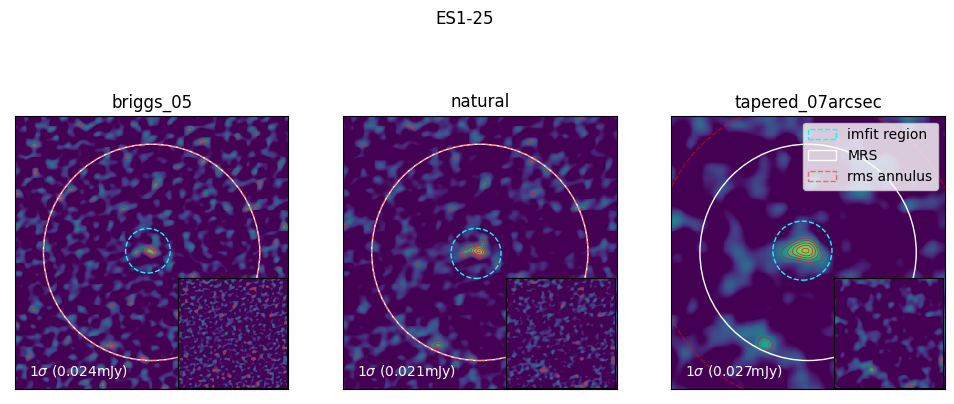

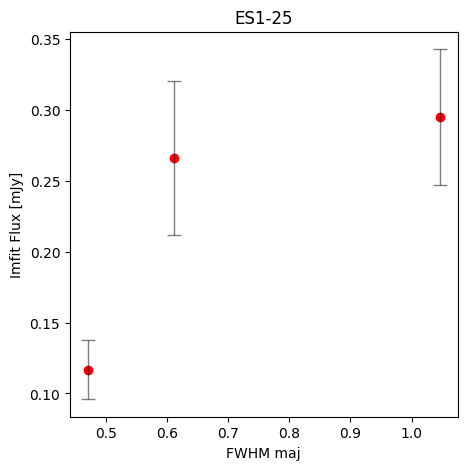

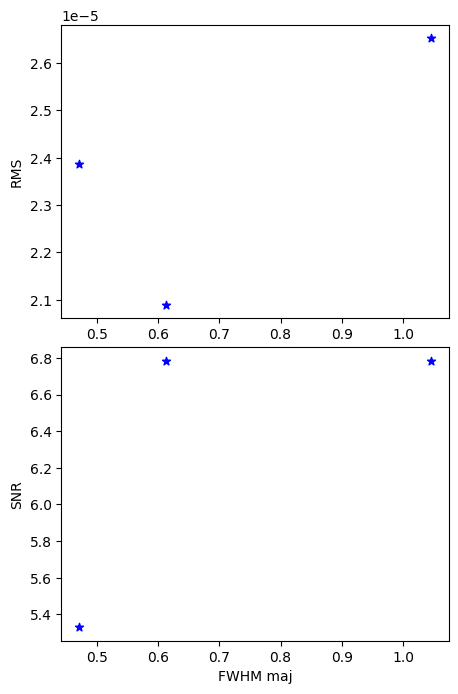

In [170]:
fig,ax = plt.subplots(1,3, figsize = (12,5))
ax = ax.ravel()
fig2,ax2 = plt.subplots(1,1, figsize = (5,5))
fig3,ax3 = plt.subplots(2,1, figsize = (5,8))
rms = []
snr = []
fwhm = []
flux = []
error = []
for img_type, i in zip(img_types, range(0,6)):
    
    file = path + img_type + bcg + "_" + img_type.split("/")[0] + ".fits"
    data,header = read_fits(file)
    ra = header['CRPIX1']
    dec = header['CRPIX2']
    wcs = WCS(header, naxis = 2)

    xlim = (ra-150, ra+150)
    ylim = (dec-150, dec+150)

    imfit_data = ast.literal_eval(df[df['BCG'] == bcg][img_type.split("/")[0]].values[0])
    imfit_radius = imfit_data[2]
    imfit_ra = imfit_data[0]
    imfit_dec = imfit_data[1]

    if img_type in ['briggs_05/', 'natural/']:
        rms_radius = round(mrs_dict[bcg]/0.045)
    else:
        rms_radius = round((6 + imfit_radius)/0.045)
    s,r = signaltonoise(data, (ra,dec), round(imfit_radius/0.045), rms_radius)

    levels = np.arange(r*2.5, r*s,sig*r, dtype=None)
    rms.append(r)
    snr.append(s)
    
    x,y = wcs.world_to_pixel(SkyCoord(imfit_ra, imfit_dec, unit = 'deg'))
    region_pix = CirclePixelRegion(center=PixCoord(x=x, y=y),radius=imfit_radius/0.045)
    mrs_pix = CirclePixelRegion(center=PixCoord(x=ra, y=dec),radius=mrs_dict[bcg]/0.045)
    rms_pix = CirclePixelRegion(center=PixCoord(x=ra, y=dec),radius=rms_radius)
    
    text = str(sig) + "$\sigma$ ({:.3f}mJy)".format(r*1000)
    
    ax[i].contour(data, levels = levels, colors='crimson', linewidths = 0.5, zorder = 1, alpha = 1)
    data[data<0] = 0
    norm = ImageNormalize(data, interval=MinMaxInterval(),stretch=LinearStretch())
    ax[i].matshow(data, origin = 'lower', cmap='viridis', norm =matplotlib.colors.SymLogNorm(linthresh = 0.0001))
    ax[i].text(x = 0.05, y = 0.05, s = text, color = 'white', transform = ax[i].transAxes)
    patch = region_pix.plot(ax=ax[i], facecolor='none', edgecolor='cyan', lw=1, alpha = 1, ls = 'dashed', label = 'imfit region')
    patch2 = mrs_pix.plot(ax=ax[i], facecolor='none', edgecolor='white', lw=1, alpha = 1, label = 'MRS')
    patch3 = rms_pix.plot(ax = ax[i], facecolor = 'none', edgecolor = 'red', lw = 1, alpha = 0.5, ls = 'dashed', label = 'rms annulus')
    
    imfit_dict = imfit_results[img_type.split("/")[0]][bcg]['deconvolved']['component0']
    if imfit_dict['ispoint'] == True:
        flux.append(imfit_results[img_type.split("/")[0]][bcg]['results']['component0']['peak']['value'])
        error.append(imfit_results[img_type.split("/")[0]][bcg]['results']['component0']['peak']['error'])
    else:
        flux.append(imfit_dict['flux']['value'][0])
        error.append(imfit_dict['flux']['error'][0])
    fwhm.append(imfit_results[img_type.split("/")[0]][bcg]['results']['component0']['beam']['beamarcsec']['major']['value'])
        
    ax[i].set_xlim(xlim)
    ax[i].set_ylim(ylim)
    ax[i].set_title(img_type.split("/")[0])
    axin = inset_axes(ax[i],width="40%", height="40%", loc=4, borderpad=0.1)
    residual_img = path + img_type + bcg + "_residual.image.fits"
    res_data,res_h = read_fits(residual_img)
    axin.contour(res_data, levels = levels, colors='crimson', linewidths = 0.5, zorder = 1, alpha = 1)
    res_data[res_data<0] = 0
    norm1 = ImageNormalize(data, interval=MinMaxInterval(),stretch=LinearStretch())
    axin.matshow(res_data, origin = 'lower', cmap='viridis', norm=matplotlib.colors.SymLogNorm(linthresh = 0.0001))
    axin.set_xlim(xlim)
    axin.set_ylim(ylim)
    axin.set_xticks([])
    axin.set_yticks([])
    
for ax1 in ax:
    ax1.set_xticks([])
    ax1.set_yticks([])
plt.subplots_adjust(wspace=0.05, hspace=0.1)
ax[2].legend()

fig.suptitle(bcg)
fig.savefig(plots_path + bcg + "_stamps.jpg", dpi = 300)

ax2.scatter(fwhm, np.array(flux)*1000, marker = 'o', color = 'red')
ax2.errorbar(fwhm, np.array(flux)*1000, yerr = np.array(error)*1000,ls = 'none', ecolor = 'black', alpha = 0.5,solid_capstyle='projecting', capsize=5, elinewidth = 1)
ax2.set_xlabel("FWHM maj")
ax2.set_ylabel("Imfit Flux [mJy]")
ax2.set_title(bcg)
fig2.savefig(plots_path + bcg + "_flux.jpg", dpi = 300)

ax3[0].scatter(fwhm, rms, marker = '*', color = 'blue')
ax3[0].set_ylabel("RMS")
ax3[1].scatter(fwhm, snr, marker = '*', color = 'blue')
ax3[1].set_xlabel("FWHM maj")
ax3[1].set_ylabel("SNR")
fig3.savefig(plots_path + bcg + "_rms_snr.jpg", dpi = 300)

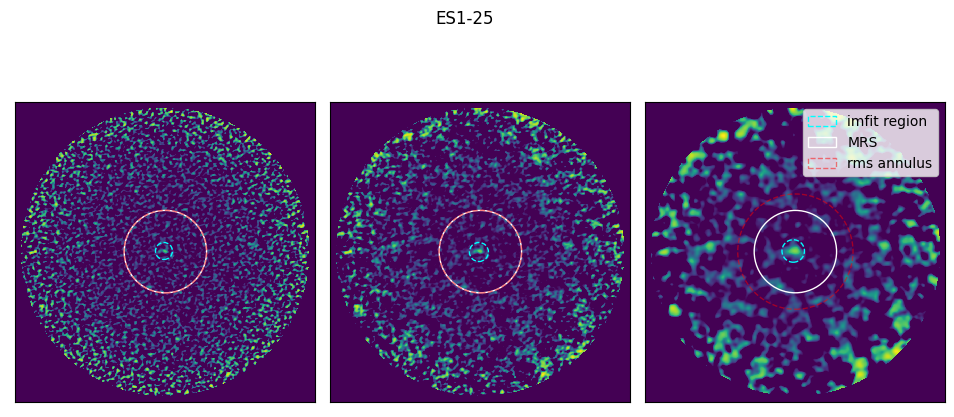

In [171]:
fig,ax = plt.subplots(1,3, figsize = (12,5))
ax = ax.ravel()
rms = []
snr = []
fwhm = []
flux = []
error = []
for img_type, i in zip(img_types, range(0,6)):
    
    file = path + img_type + bcg + "_" + img_type.split("/")[0] + ".fits"
    data,header = read_fits(file)
    ra = header['CRPIX1']
    dec = header['CRPIX2']
    wcs = WCS(header, naxis = 2)

    imfit_data = ast.literal_eval(df[df['BCG'] == bcg][img_type.split("/")[0]].values[0])
    imfit_radius = imfit_data[2]
    imfit_ra = imfit_data[0]
    imfit_dec = imfit_data[1]

    if img_type in ['briggs_05/', 'natural/']:
        rms_radius = round(mrs_dict[bcg]/0.045)
    else:
        rms_radius = round((6 + imfit_radius)/0.045)
    x,y = wcs.world_to_pixel(SkyCoord(imfit_ra, imfit_dec, unit = 'deg'))
    region_pix = CirclePixelRegion(center=PixCoord(x=x, y=y),radius=imfit_radius/0.045)
    mrs_pix = CirclePixelRegion(center=PixCoord(x=ra, y=dec),radius=mrs_dict[bcg]/0.045)
    rms_pix = CirclePixelRegion(center=PixCoord(x=ra, y=dec),radius=rms_radius)
    
#     ax[i].contour(data, levels = levels, colors='crimson', linewidths = 0.5, zorder = 1, alpha = 1)
    data[data<0] = 0
    norm = ImageNormalize(data, interval=MinMaxInterval(),stretch=LinearStretch())
    ax[i].matshow(data, origin = 'lower', cmap='viridis', norm =matplotlib.colors.SymLogNorm(linthresh = 0.0001))
    patch = region_pix.plot(ax=ax[i], facecolor='none', edgecolor='cyan', lw=1, alpha = 1, ls = 'dashed', label = 'imfit region')
    patch2 = mrs_pix.plot(ax=ax[i], facecolor='none', edgecolor='white', lw=1, alpha = 1, label = 'MRS')
    patch3 = rms_pix.plot(ax = ax[i], facecolor = 'none', edgecolor = 'red', lw = 1, alpha = 0.5, ls = 'dashed', label = 'rms annulus')
    
    
    imfit_dict = imfit_results[img_type.split("/")[0]][bcg]['deconvolved']['component0']
    if imfit_dict['ispoint'] == True:
        flux.append(imfit_results[img_type.split("/")[0]][bcg]['results']['component0']['peak']['value'])
        error.append(imfit_results[img_type.split("/")[0]][bcg]['results']['component0']['peak']['error'])
    else:
        flux.append(imfit_dict['flux']['value'][0])
        error.append(imfit_dict['flux']['error'][0])
    fwhm.append(imfit_results[img_type.split("/")[0]][bcg]['results']['component0']['beam']['beamarcsec']['major']['value'])
    
for ax1 in ax:
    ax1.set_xticks([])
    ax1.set_yticks([])
plt.subplots_adjust(wspace=0.05, hspace=0.1)
ax[2].legend()

fig.suptitle(bcg)
fig.savefig(plots_path + bcg + "_stamps_full.jpg", dpi = 300)